# Sequantial Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

seed = 30

## Stock Prices

problem statement: fixed window size(5) prediction

$$x_{inputs} = \begin{bmatrix} \text{Open} & \text{High} & \text{Low} & \text{Adj Close} & \text{Volume} \end{bmatrix}$$

$$\begin{aligned} 
x_{0:4} &\rightarrow & x_{5} \\ &\vdots & \\ x_{T-5:T-1} &\rightarrow & x_{T}
\end{aligned}$$

* shape: `(N, T, I)`
* `N`: number of data / `T`: total time step / `I`: input feature size

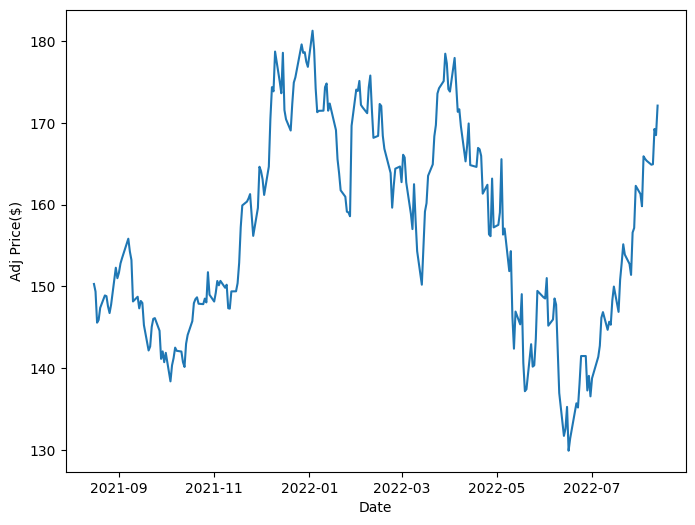

In [2]:
AAPL = pd.read_csv('./data/AAPL.csv')
AAPL['Date'] = pd.to_datetime(AAPL['Date'])  # change to datetime dtype
AAPL = AAPL.set_index('Date').loc[:, ['Open', 'High', 'Low', 'Adj Close', 'Volume']]
AAPL['Volume'] = AAPL['Volume'] / 1000000

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(AAPL.index, AAPL['Adj Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Adj Price($)')
plt.show()

In [3]:
AAPL.head()

,Open,High,Low,Adj Close,Volume
Date,,,,,
2021-08-16,148.539993,151.190002,146.470001,150.277893,103.2960
2021-08-17,150.229996,151.679993,149.089996,149.353088,92.2297
2021-08-18,149.800003,150.720001,146.149994,145.544434,86.3260
2021-08-19,145.029999,148.000000,144.500000,145.882538,86.9603
2021-08-20,147.440002,148.500000,146.779999,147.364243,60.5496


In [4]:
window_size = 5
inputs_index = np.arange(window_size)[None,:] + np.arange(len(AAPL)-window_size)[:, None]
target_index = np.arange(window_size, len(AAPL))

inputs = AAPL.to_numpy()[inputs_index]
targets = AAPL.to_numpy()[target_index, 3]

np.set_printoptions(precision=4)

print(f'Input Index:\n{inputs_index[:3]}\n')
print(f'Input Data: {inputs.shape}\n{inputs[:3, :]}\n')
print(f'Target Index:\n{target_index[:3]}\n')
print(f'Target Data: {targets.shape}\n{targets[:3]}\n')

Input Index:
[[0 1 2 3 4]
 [1 2 3 4 5]
 [2 3 4 5 6]]

Input Data: (246, 5, 5)
[[[148.54   151.19   146.47   150.2779 103.296 ]
  [150.23   151.68   149.09   149.3531  92.2297]
  [149.8    150.72   146.15   145.5444  86.326 ]
  [145.03   148.     144.5    145.8825  86.9603]
  [147.44   148.5    146.78   147.3642  60.5496]]

 [[150.23   151.68   149.09   149.3531  92.2297]
  [149.8    150.72   146.15   145.5444  86.326 ]
  [145.03   148.     144.5    145.8825  86.9603]
  [147.44   148.5    146.78   147.3642  60.5496]
  [148.31   150.19   147.89   148.8758  60.1318]]

 [[149.8    150.72   146.15   145.5444  86.326 ]
  [145.03   148.     144.5    145.8825  86.9603]
  [147.44   148.5    146.78   147.3642  60.5496]
  [148.31   150.19   147.89   148.8758  60.1318]
  [149.45   150.86   149.15   148.7863  48.6064]]]

Target Index:
[5 6 7]

Target Data: (246,)
[148.8758 148.7863 147.5333]



## Alphabets

problem statement

$$\begin{aligned}
A &\rightarrow& B \\ B &\rightarrow& C \\ &\vdots & \\ Y &\rightarrow& Z 
\end{aligned}$$

In [5]:
alphabets = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
print(f'Alphabets:\n{alphabets}')
alphabet_vocab = {a: index for index, a in enumerate(alphabets)}
print(f'Vocab:\n{alphabet_vocab}')

alphabets_array = np.array([alphabet_vocab.get(w) for w in alphabets])
# change the shape: (N, T, I)
# N: number of data / T: total time step / I: input feature size
inputs = alphabets_array[None, :-1, None]  # A ~ Y
inputs = inputs.astype(np.float32)
targets = alphabets_array[1:]  # B ~ Z
print(f'Input Data: {inputs.shape}\n{inputs[:, :3, :]}\n')
print(f'Target Data: {targets.shape}\n{targets[:3]}\n')

Alphabets:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Vocab:
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
Input Data: (1, 25, 1)
[[[0.]
  [1.]
  [2.]]]

Target Data: (25,)
[1 2 3]



https://www.tensorflow.org/tutorials/structured_data/time_series

# Recurrent Neural Network

* [`tf.keras.layers.SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN): 1 layer RNN
* [`tf.keras.layers.RNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)
* [`tf.keras.layers.SimpleRNNCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNNCell)
* Tutorial RNN: https://www.tensorflow.org/guide/keras/rnn?hl=ko

In [6]:
rnn_layer = tf.keras.layers.SimpleRNN(
    units=5, 
    activation='tanh', 
    return_sequences=True,  # return all outputs
    return_state=True  # return hiddens
)
outputs, hiddens = rnn_layer(inputs)
print(f'Shape of outputs: {outputs.shape}')  # (N, T, H)
print(f'Shape of hiddens: {hiddens.shape}')  # (N, H)

Shape of outputs: (1, 25, 5)
Shape of hiddens: (1, 5)


In [7]:
# same with SimpleRNN
rnn_layer = tf.keras.layers.RNN(
    cell=tf.keras.layers.SimpleRNNCell(units=5, activation='tanh'),
    return_sequences=True,
    return_state=True,
)
outputs, hiddens = rnn_layer(inputs)
print(f'Shape of outputs: {outputs.shape}')  # (N, T, H)
print(f'Shape of hiddens: {hiddens.shape}')  # (N, H)

Shape of outputs: (1, 25, 5)
Shape of hiddens: (1, 5)


## Deep RNN


* [`tf.keras.layers.StackedRNNCells`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StackedRNNCells)

In [8]:
tf.random.set_seed(seed)

num_layers = 3
rnn_cells = [tf.keras.layers.SimpleRNNCell(units=5, activation='tanh') for _ in range(num_layers)]
stacked_rnn_cells = tf.keras.layers.StackedRNNCells(rnn_cells)
rnn_layer = tf.keras.layers.RNN(
    cell=stacked_rnn_cells,
    return_sequences=True,
    return_state=True,
)
outputs, *hiddens = rnn_layer(inputs)

print(f'Shape of outputs: {outputs.shape}')  # (N, T, H)
print(f'Last time-stamp output = {outputs[:, -1, :]}\n')
for i, h in enumerate(hiddens, 1):
    print(f'Layer {i}: {h.shape} = {h}')


Shape of outputs: (1, 25, 5)
Last time-stamp output = [[-0.9903  0.1701  0.9428 -0.0743  0.4249]]

Layer 1: (1, 5) = [[ 0.9998 -1.      1.      1.     -1.    ]]
Layer 2: (1, 5) = [[-0.1697 -0.8102 -0.6282  0.9945  0.5873]]
Layer 3: (1, 5) = [[-0.9903  0.1701  0.9428 -0.0743  0.4249]]


## Bidirectional RNN

* [`tf.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [9]:
tf.random.set_seed(seed)

rnn_layer = tf.keras.layers.RNN(
    cell=tf.keras.layers.SimpleRNNCell(units=5, activation='tanh'),
    return_sequences=True,
    return_state=True
)
bidirec_rnn_layer = tf.keras.layers.Bidirectional(
    layer=rnn_layer,
    merge_mode='concat'
)
outputs, *hiddens = bidirec_rnn_layer(inputs)

print(f'Shape of outputs: {outputs.shape}')  # (N, T, 2H)
print(f'Last time-stamp forward output = {outputs[:, -1, :5]}')
print(f'Last time-stamp backward output = {outputs[:, 0, 5:]}\n')
for i, h in enumerate(hiddens, 1):
    print(f'Hidden {i}: {h.shape} = {h}')

Shape of outputs: (1, 25, 10)
Last time-stamp forward output = [[ 0.9998 -1.      1.      1.     -1.    ]]
Last time-stamp backward output = [[-0.654  -0.7366 -0.7405  0.2256 -0.1767]]

Hidden 1: (1, 5) = [[ 0.9998 -1.      1.      1.     -1.    ]]
Hidden 2: (1, 5) = [[-0.654  -0.7366 -0.7405  0.2256 -0.1767]]


## LSTM Layer

* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
* [`tf.keras.layers.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell)

In [10]:
lstm_layer = tf.keras.layers.LSTM(
    units=5,
    activation='tanh',  # activation function
    recurrent_activation='sigmoid',  # gate function
    return_sequences=True,
    return_state=True,
)
outputs, hiddens, cells = lstm_layer(inputs)
print(f'Shape of outputs: {outputs.shape}')  # (N, T, H)
print(f'Shape of hiddens: {hiddens.shape}')  # (N, H)
print(f'Shape of cells: {cells.shape}')  # (N, H)

Shape of outputs: (1, 25, 5)
Shape of hiddens: (1, 5)
Shape of cells: (1, 5)


In [11]:
lstm_layer = tf.keras.layers.RNN(
    cell=tf.keras.layers.LSTMCell(units=5, activation='tanh', recurrent_activation='sigmoid'),
    return_sequences=True,
    return_state=True
)
outputs, hiddens, cells = lstm_layer(inputs)
print(f'Shape of outputs: {outputs.shape}')  # (N, T, H)
print(f'Shape of hiddens: {hiddens.shape}')  # (N, H)
print(f'Shape of cells: {cells.shape}')  # (N, H)

Shape of outputs: (1, 25, 5)
Shape of hiddens: (1, 5)
Shape of cells: (1, 5)


## GRU Layer

* [`tf.keras.layers.GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)
* [`tf.keras.layers.GRUCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell)

In [12]:
gru_layer = tf.keras.layers.GRU(
    units=5,
    activation='tanh',  # activation function
    recurrent_activation='sigmoid',  # gate function
    return_sequences=True,
    return_state=True,
)
outputs, hiddens = gru_layer(inputs)
print(f'Shape of outputs: {outputs.shape}')  # (N, T, H)
print(f'Shape of hiddens: {hiddens.shape}')  # (N, H)

Shape of outputs: (1, 25, 5)
Shape of hiddens: (1, 5)


In [13]:
gru_layer = tf.keras.layers.RNN(
    cell=tf.keras.layers.GRUCell(units=5, activation='tanh', recurrent_activation='sigmoid'),
    return_sequences=True,
    return_state=True
)
outputs, hiddens = gru_layer(inputs)
print(f'Shape of outputs: {outputs.shape}')  # (N, T, H)
print(f'Shape of hiddens: {hiddens.shape}')  # (N, H)

Shape of outputs: (1, 25, 5)
Shape of hiddens: (1, 5)


---

# Natural Language Processing

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

seed = 30

## Text Preprocessing

### Problem: Name Classifier

Use RNN to classify 5 countries("German", "United States", "Spain", "Korean", "Russian") names.

### 0. Load Data

In [15]:
np.random.seed(seed)

data_path = Path('./data/names')

names_train = pd.read_csv(data_path / 'names_train.csv')
names_test = pd.read_csv(data_path / 'names_test.csv')

# label preprocessing
INDEX2LABEL = list(names_train['country'].unique())
LABEL2INDEX = {label: index for index, label in enumerate(INDEX2LABEL)}
print(f'Label-to-Index: {LABEL2INDEX}\n')
names_counts = names_train['country'].value_counts()
print(names_counts)

Label-to-Index: {'German': 0, 'United States': 1, 'Spain': 2, 'Korean': 3, 'Russian': 4}

Spain            9995
Russian          9989
German           9984
United States    9377
Korean           2957
Name: country, dtype: int64


### 1. Tokenization

Use character to classify the name. e.g. 'Simon':

```
inputs: 'S', 'i', 'm', 'o', 'n'
outputs: United States
```

In [16]:
def tokenize(name):
    tokens = list(name)
    return tokens

tokens = tokenize('Simon')
print(tokens)

['S', 'i', 'm', 'o', 'n']


In [17]:
x_train = names_train['name'].apply(tokenize).to_list()
x_test = names_test['name'].apply(tokenize).to_list()

### 2. Create Vocabulary


* `[UNK]`: if a new letter is never seen in train data, it will refer to this token
* `[PAD]`: use it to match input size

In [18]:
VOCAB2INDEX = {}
VOCAB2INDEX['[PAD]'] = 0
VOCAB2INDEX['[UNK]'] = 1
unique_tokens = set()  # to get non_duplicate tokens
for s in x_train:
    unique_tokens.update(set(s))
print(f'Number of unique tokens: {len(unique_tokens)}')
# create vocabulary 
for index, token in enumerate(unique_tokens, 2):
    VOCAB2INDEX[token] = index
INDEX2VOCAB = list(VOCAB2INDEX.keys()) 

Number of unique tokens: 220


### 3. Map to Vocab-to-Index

In [19]:
def encode(tokens):
    idx_tokens = []
    for token in tokens:
        if VOCAB2INDEX.get(token) is None:
            idx = VOCAB2INDEX['[UNK]']
        else:
            idx = VOCAB2INDEX[token]
        idx_tokens.append(idx)
    return idx_tokens

def decode(idx_tokens, keep_pad=False):
    tokens = []
    for idx in idx_tokens:
        token = INDEX2VOCAB[idx]
        if not keep_pad and token == '[PAD]':
            continue
        tokens.append(token)
    return ''.join(tokens)

In [20]:
print(f'Tokens: {tokens}')
idx_tokens = encode(tokens)
print(f'Encoded tokens: {idx_tokens}')
print(f'Decoded tokens: {decode(idx_tokens)}')

Tokens: ['S', 'i', 'm', 'o', 'n']
Encoded tokens: [44, 183, 119, 160, 115]
Decoded tokens: Simon


### 4. Padding

```
length = 15: 
'D', 'i', 'e', 't', 'h', 'a', 'r', 'd', ' ', 'T', 'e', 'x', 't', 'o', 'r'

length = 11 + 4: 
'M', 'a', 'r', 'c', 'o', ' ', 'D', 'i', 'e', 't', 'z', '[PAD]', '[PAD]', '[PAD]', '[PAD]'
```

In [21]:
sample_data = [
    ['D', 'i', 'e', 't', 'h', 'a', 'r', 'd', ' ', 'T', 'e', 'x', 't', 'o', 'r'],
    ['M', 'a', 'r', 'c', 'o', ' ', 'D', 'i', 'e', 't', 'z']
]
print(f'Names data: {list(map(lambda x: "".join(x), sample_data))}')
print(f'Length of tokens: {list(map(len, sample_data))}')

idx_tokens = list(map(encode, sample_data))

Names data: ['Diethard Textor', 'Marco Dietz']
Length of tokens: [15, 11]


* [`tf.keras.utils.pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)

In [22]:
padded_tokens = tf.keras.utils.pad_sequences(
    idx_tokens, 
    value=VOCAB2INDEX['[PAD]'], 
    padding='post',
    maxlen=None
)
print(f'Padded Tokens: {padded_tokens.shape}\n{padded_tokens}')

Padded Tokens: (2, 15)
[[150 183  47  90  77 190 136  32 194  84  47  11  90 160 136]
 [ 15 190 136 215 160 194 150 183  47  90 213   0   0   0   0]]


### Build dataset

In [23]:
# select 2.5% data from train data as validation data
ratio = 0.025
train_idxes = []
valid_idxes = []
for label in INDEX2LABEL:
    index = names_train.loc[names_train['country'] == label].index.to_numpy()
    valid_idx = np.random.choice(index, size=(int(len(index)*ratio),), replace=False)
    train_idx = index[~np.isin(index, valid_idx)]
    train_idxes.append(train_idx)
    valid_idxes.append(valid_idx)
train_idxes = np.concatenate(train_idxes, axis=0)
valid_idxes = np.concatenate(valid_idxes, axis=0)

# process train data: shuffle first
df_train = names_train.iloc[train_idxes].sample(frac=1).reset_index(drop=True)
df_valid = names_train.iloc[valid_idxes].sample(frac=1).reset_index(drop=True)
df_test = names_test.sample(frac=1).reset_index(drop=True)
print(f'Number of train data: {len(df_train)}')
print(f'Number of valid data: {len(df_valid)}')
print(f'Number of test data: {len(df_test)}')

Number of train data: 41248
Number of valid data: 1054
Number of test data: 494


* [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
* [`padded_batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch)

In [24]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

def data_generator(df):
    names = df['name'].apply(tokenize).apply(encode).to_list()
    labels = df['country'].apply(LABEL2INDEX.get).to_list()
    for index in range(len(names)):
        yield names[index], labels[index]

def get_batches(df, test=False):
    output_signature = (
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # names
        tf.TensorSpec(shape=(), dtype=tf.int32)  # labels
    )  # shape, except the batch_size
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(df), 
        output_signature=output_signature
    )
    if not test:
        dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    batches = dataset.padded_batch(
        BATCH_SIZE, 
        padded_shapes=(tf.TensorShape([None,]), []), 
        padding_values=(VOCAB2INDEX['[PAD]'], 0)
    )
    return batches

In [25]:
train_batches = get_batches(df_train, test=False)
validation_batches = get_batches(df_valid, test=True)
test_batches = get_batches(df_test, test=True)

for inputs, labels in train_batches:
    break

print(f'Shape of Inputs: {inputs.shape}\nFirst example: {inputs[0]}')
print(f'Shape of Labels: {labels.shape}')

Shape of Inputs: (64, 34)
First example: [101 190 183 119  47 194  80 190  37 110  47  90 194  25  37 215 123 115
  90 190 136 190   0   0   0   0   0   0   0   0   0   0   0   0]
Shape of Labels: (64,)


## Embedding Layer

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

In [26]:
vocab_size = len(VOCAB2INDEX)
embedding_size = 10
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size, 
    output_dim=embedding_size, 
)
outputs = embedding_layer(inputs)

print(f'Shape of outputs: {outputs.shape}')
print(f'Shape of Embedding Matrix: {embedding_layer.weights[0].shape}')

Shape of outputs: (64, 34, 10)
Shape of Embedding Matrix: (222, 10)


## RNN Model

### Network

* Input Size = (B, T, vocab_size)
* Output Size = (B, 5)
* Loss Function: Cross Entropy Loss
* Optimizer: Adam
* RNN Layer: Use LSTM

In [27]:
EPOCHS = 5
vocab_size = len(VOCAB2INDEX)
embedding_size = 10
hidden_size = 10
output_size = len(LABEL2INDEX)
checkpoint_dir = Path('./checkpoints/rnn')

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size),
    tf.keras.layers.LSTM(units=hidden_size),  # output is hidden states of last time-stamp
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(output_size) 
])
model.summary()

model_name = 'model_name'
checkpoint_path = checkpoint_dir / model_name

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weight_only=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[cp_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          2220      
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 8)                 88        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 3,193
Trainable params: 3,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
    642/Unknown - 6s 7ms/step - loss: 0.7721 - accuracy: 0.6650

INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


645/645 [==============================] - 8s 11ms/step - loss: 0.7707 - accuracy: 0.6655 - val_loss: 0.4302 - val_accuracy: 0.8036
Epoch 2/5
640/645 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.8668

INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


645/645 [==============================] - 7s 11ms/step - loss: 0.3368 - accuracy: 0.8671 - val_loss: 0.2688 - val_accuracy: 0.8947
Epoch 3/5
642/645 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9037

INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


645/645 [==============================] - 7s 10ms/step - loss: 0.2447 - accuracy: 0.9039 - val_loss: 0.2321 - val_accuracy: 0.9108
Epoch 4/5
645/645 [==============================] - 6s 9ms/step - loss: 0.2182 - accuracy: 0.9137 - val_loss: 0.2128 - val_accuracy: 0.9108
Epoch 5/5
644/645 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9205

INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


INFO:tensorflow:Assets written to: checkpoints\rnn\model_name\assets


645/645 [==============================] - 8s 11ms/step - loss: 0.2013 - accuracy: 0.9206 - val_loss: 0.2027 - val_accuracy: 0.9156


 1/10 [==>...........................] - ETA: 1s - loss: 0.2672 - accuracy: 0.8594WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10 batches). You may need to use the repeat() function when building your dataset.


10/10 [==============================] - 0s 5ms/step - loss: 0.1597 - accuracy: 0.9352
Test Loss: 0.1597, Accuracy: 0.9352


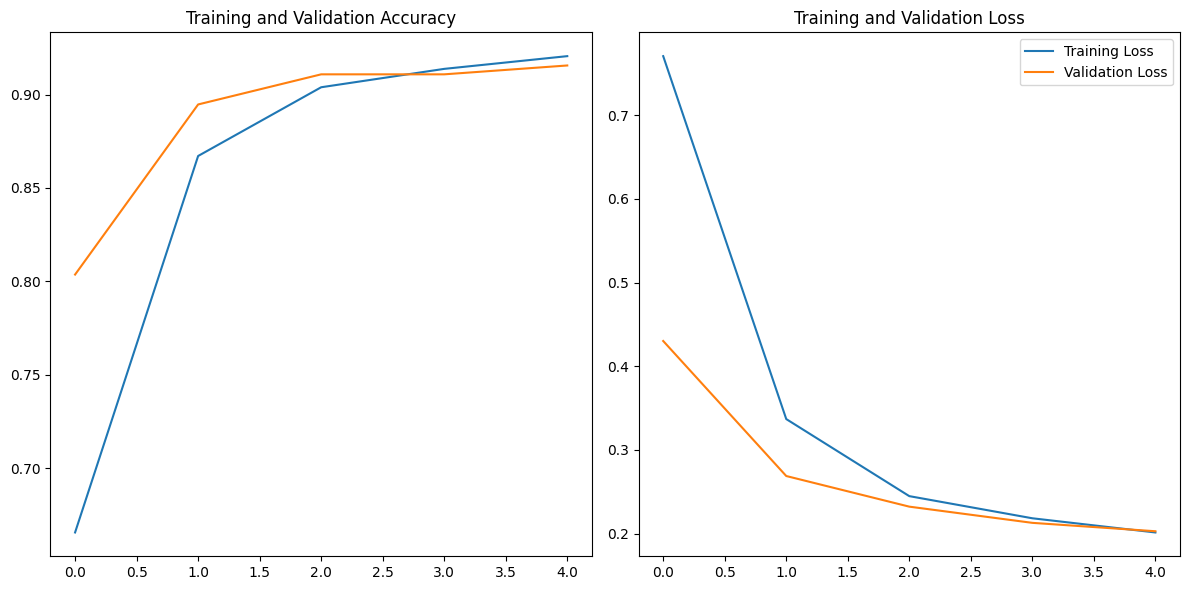

In [28]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.plot(epochs_range, acc, label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    ax2.plot(epochs_range, loss, label='Training Loss')
    ax2.plot(epochs_range, val_loss, label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    plt.tight_layout()
    plt.legend()
    plt.show()

new_model = tf.keras.models.load_model(checkpoint_path)

loss, accuracy = new_model.evaluate(test_batches, steps=10)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

plot_results(history)

### Try your name

In [29]:
def predict(model, name):
    tokens = tokenize(name)
    idx_tokens = encode(tokens)
    pred = model.predict(np.array([idx_tokens]))
    return INDEX2LABEL[pred.argmax()]

In [30]:
name = input('Please Insert Your Name: ')
pred = predict(model, name)
print(f'Your Name = {name}, Prediction = {pred}')

1/1 [==============================] - 0s 182ms/step
Your Name = 장지수, Prediction = Korean


---